Full tutorial - https://github.com/naklecha/llama3-from-scratch?tab=readme-ov-file 

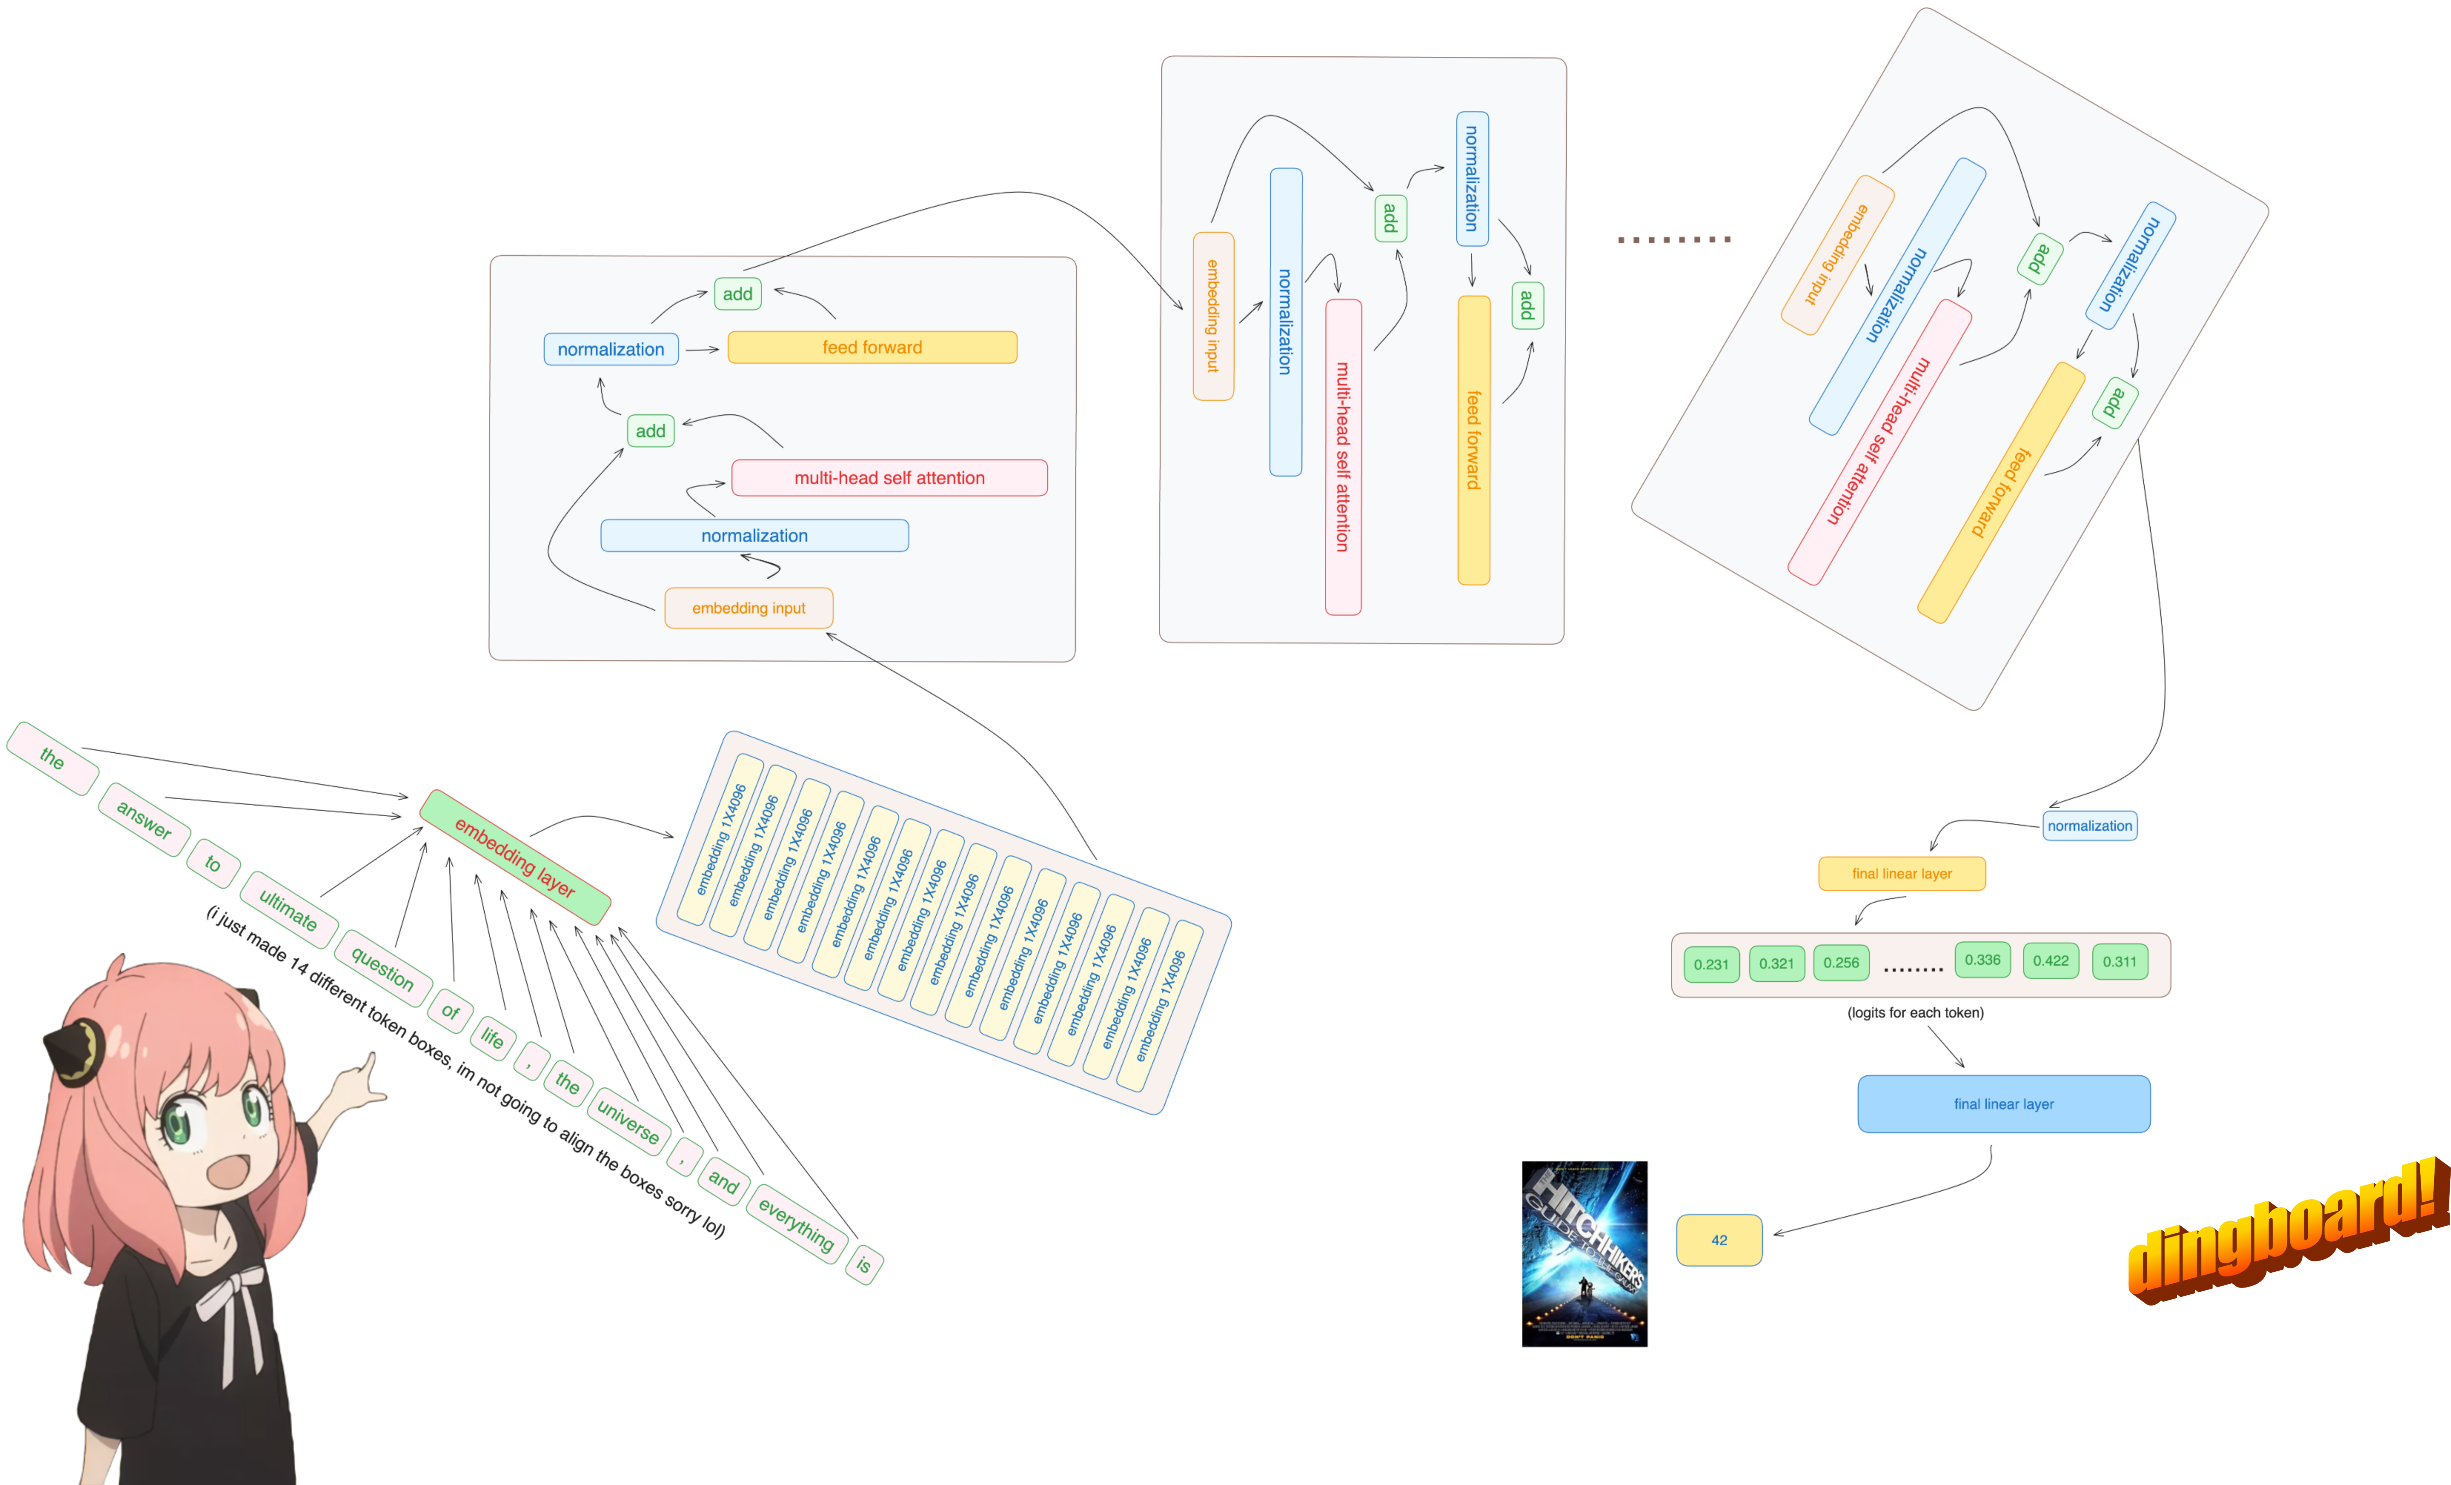

# Everything All At Once - Full inference code

In [1]:
## Run this block standalone
import tiktoken, torch, json
from tiktoken.load import load_tiktoken_bpe

model_path = "/Users/ammarh/.llama/checkpoints/Meta-Llama3.1-8B-Instruct/"

## Tokenizer
mergeable_ranks = load_tiktoken_bpe(model_path + "tokenizer.model")
special_tokens = [
            "<|begin_of_text|>",
            "<|end_of_text|>",
            "<|reserved_special_token_0|>",
            "<|reserved_special_token_1|>",
            "<|reserved_special_token_2|>",
            "<|reserved_special_token_3|>",
            "<|start_header_id|>",
            "<|end_header_id|>",
            "<|reserved_special_token_4|>",
            "<|eot_id|>",  # end of turn
        ] + [f"<|reserved_special_token_{i}|>" for i in range(5, 256 - 5)]
tokenizer = tiktoken.Encoding(
    name='tokenizer.model',
    pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\S)|\s+",
    mergeable_ranks=mergeable_ranks,
    special_tokens={token: len(mergeable_ranks) + i for i, token in enumerate(special_tokens)},
)

## Model
model = torch.load(model_path + "consolidated.00.pth")

## Config
with open(model_path + "params.json", "r") as f:
    config = json.load(f)

In [64]:
## Normalization function
def rms_norm(tensor, norm_weights):
    return (tensor * torch.rsqrt(tensor.pow(2).mean(-1, keepdim=True) + config["norm_eps"])) * norm_weights

def get_rope_embeddings(tokens_len):
    zero_to_one_split_into_64_parts = torch.tensor(range(64))/64
    zero_to_one_split_into_64_parts
    freqs = 1.0 / (config["rope_theta"] ** zero_to_one_split_into_64_parts)
    freqs_for_each_token = torch.outer(torch.arange(tokens_len), freqs)
    freqs_cis = torch.polar(torch.ones_like(freqs_for_each_token), freqs_for_each_token)
    return freqs_cis

def apply_first_embeddings_layer(tokens):
    tokens = torch.tensor(tokens)
    ## Input Embedding Layer
    embedding_layer = torch.nn.Embedding(config["vocab_size"], config["dim"])
    embedding_layer.weight.data.copy_(model["tok_embeddings.weight"])
    token_embeddings_unnormalized = embedding_layer(tokens).to(torch.bfloat16)
    return token_embeddings_unnormalized

def apply_transformer_blocks(token_embeddings_unnormalized, config):
    # Read from config
    n_heads = config["n_heads"]
    n_kv_heads = config["n_kv_heads"]
    n_layers = config["n_layers"]
    dim = config["dim"]
    # Get RoPE embeddings
    freqs_cis = get_rope_embeddings(token_embeddings_unnormalized.shape[0])
    final_embedding = token_embeddings_unnormalized # initialize with the token wise embeddings
    for layer in range(n_layers):
        qkv_attention_store = []
        layer_embedding_norm = rms_norm(final_embedding, model[f"layers.{layer}.attention_norm.weight"])
        # Fetch the QKV for this layer
        q_layer = model[f"layers.{layer}.attention.wq.weight"]
        q_layer = q_layer.view(n_heads, q_layer.shape[0] // n_heads, dim)
        k_layer = model[f"layers.{layer}.attention.wk.weight"]
        k_layer = k_layer.view(n_kv_heads, k_layer.shape[0] // n_kv_heads, dim)
        v_layer = model[f"layers.{layer}.attention.wv.weight"]
        v_layer = v_layer.view(n_kv_heads, v_layer.shape[0] // n_kv_heads, dim)
        w_layer = model[f"layers.{layer}.attention.wo.weight"]
        for head in range(n_heads):
            q_layer_head = q_layer[head] # 128,4096 (where 4096 is the dim of the word embedding)
            k_layer_head = k_layer[head//4] # key weights are shared across 4 heads (module operator which just results in 0,1,2,3 ie 4 values of when 32 is divided by 4)
            v_layer_head = v_layer[head//4] # value weights are shared across 4 heads
            q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T)
            k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T)
            v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T)

            # positional embedding applied to query vectors
            q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
            q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
            q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
            q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
            
            # positional embedding applied to key vectors
            k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
            k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
            k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
            k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)

            # create a mask over future tokens for attention
            qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
            mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=token_embeddings_unnormalized.device)
            mask = torch.triu(mask, diagonal=1)
            qk_per_token_after_masking = qk_per_token + mask
            qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)

            # multiply by value weights to get the QKV for self attention
            qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
            qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
            qkv_attention_store.append(qkv_attention)

        # stack all the heads back together and run a linearprojection through the Wo matrix
        stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
        w_layer = model[f"layers.{layer}.attention.wo.weight"]
        embedding_delta = torch.matmul(stacked_qkv_attention, w_layer.T)

        # add to the unnormalized layer wise embeddings input
        embedding_after_edit = final_embedding + embedding_delta

        # normalize the embeddings + attention embeddings
        embedding_after_edit_normalized = rms_norm(embedding_after_edit, model[f"layers.{layer}.ffn_norm.weight"])

        # run the SwiGLU feed forward network
        w1 = model[f"layers.{layer}.feed_forward.w1.weight"]
        w2 = model[f"layers.{layer}.feed_forward.w2.weight"]
        w3 = model[f"layers.{layer}.feed_forward.w3.weight"]
        # output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
        fc_gate  = torch.matmul(embedding_after_edit_normalized, w1.T) # up projection with non-linearity
        siLU_fc_gate = torch.functional.F.silu(fc_gate)
        fc_up = torch.matmul(embedding_after_edit_normalized, w3.T) # up projection
        elem_wise_mult = siLU_fc_gate * fc_up
        output_after_feedforward = torch.matmul(elem_wise_mult, w2.T) # down projection
        # output embedding for this layer
        final_embedding = embedding_after_edit+output_after_feedforward
    return final_embedding

def apply_last_layer(final_embedding):
    # Apply a final normalization to the embeddings here
    final_embedding = rms_norm(final_embedding, model["norm.weight"])
    logits = torch.matmul(final_embedding[-1], model["output.weight"].T)
    next_token = torch.argmax(logits, dim=-1)
    return next_token
## Input Tokenization 
# prompt = "the answer to the ultimate question of life, the universe, and everything is "
prompt = "jack and jill went up the hill to fetch a "
# prompt = "this is the only part of the codebase where i "
# prompt = "boo boo boo boo bah bah bah bah"
tokens = [128000] + tokenizer.encode(prompt)


### Unroll for a few iterations
for ur in range(5):
    token_embeddings_unnormalized = apply_first_embeddings_layer(tokens)
    final_embedding = apply_transformer_blocks(token_embeddings_unnormalized, config)
    next_token = apply_last_layer(final_embedding)
    print(f"{ur} -> {tokenizer.decode([next_token.item()])}")
    tokens.append(next_token.item())

0 ->  p
1 -> ail
2 ->  of
3 ->  water
4 -> 



# Breakdown of all the components
## Tokenizer 

In [3]:
from pathlib import Path
import tiktoken
from tiktoken.load import load_tiktoken_bpe
import torch
import json
import matplotlib.pyplot as plt

model_path = "/Users/ammarh/.llama/checkpoints/Meta-Llama3.1-8B-Instruct/"
tokenizer_path = model_path + "tokenizer.model"
special_tokens = [
            "<|begin_of_text|>",
            "<|end_of_text|>",
            "<|reserved_special_token_0|>",
            "<|reserved_special_token_1|>",
            "<|reserved_special_token_2|>",
            "<|reserved_special_token_3|>",
            "<|start_header_id|>",
            "<|end_header_id|>",
            "<|reserved_special_token_4|>",
            "<|eot_id|>",  # end of turn
        ] + [f"<|reserved_special_token_{i}|>" for i in range(5, 256 - 5)]
mergeable_ranks = load_tiktoken_bpe(tokenizer_path)
tokenizer = tiktoken.Encoding(
    name=Path(tokenizer_path).name,
    pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\S)|\s+",
    mergeable_ranks=mergeable_ranks,
    special_tokens={token: len(mergeable_ranks) + i for i, token in enumerate(special_tokens)},
)

tokenizer.decode(tokenizer.encode("hello world!"))


'hello world!'

In [4]:
print(tokenizer.encode("hello world! ammar"))
for i, m in zip(range(5), mergeable_ranks):
    print(f"{m} -> {mergeable_ranks[m]}")

reverse_dict = {v: k for k, v in mergeable_ranks.items()}
reverse_dict[len(reverse_dict)-1]
print(len(mergeable_ranks))


[15339, 1917, 0, 1097, 5730]
b'!' -> 0
b'"' -> 1
b'#' -> 2
b'$' -> 3
b'%' -> 4
128000


# Model

In [5]:
# Code to read in a pytorch model
model = torch.load(model_path + "consolidated.00.pth")
print(json.dumps(list(model.keys())[:20], indent=4))

[
    "tok_embeddings.weight",
    "layers.0.attention.wq.weight",
    "layers.0.attention.wk.weight",
    "layers.0.attention.wv.weight",
    "layers.0.attention.wo.weight",
    "layers.0.feed_forward.w1.weight",
    "layers.0.feed_forward.w3.weight",
    "layers.0.feed_forward.w2.weight",
    "layers.0.attention_norm.weight",
    "layers.0.ffn_norm.weight",
    "layers.1.attention.wq.weight",
    "layers.1.attention.wk.weight",
    "layers.1.attention.wv.weight",
    "layers.1.attention.wo.weight",
    "layers.1.feed_forward.w1.weight",
    "layers.1.feed_forward.w3.weight",
    "layers.1.feed_forward.w2.weight",
    "layers.1.attention_norm.weight",
    "layers.1.ffn_norm.weight",
    "layers.2.attention.wq.weight"
]


In [6]:
for m in model:
    print(f"{m} -> {type(model[m])}")
    

tok_embeddings.weight -> <class 'torch.Tensor'>
layers.0.attention.wq.weight -> <class 'torch.Tensor'>
layers.0.attention.wk.weight -> <class 'torch.Tensor'>
layers.0.attention.wv.weight -> <class 'torch.Tensor'>
layers.0.attention.wo.weight -> <class 'torch.Tensor'>
layers.0.feed_forward.w1.weight -> <class 'torch.Tensor'>
layers.0.feed_forward.w3.weight -> <class 'torch.Tensor'>
layers.0.feed_forward.w2.weight -> <class 'torch.Tensor'>
layers.0.attention_norm.weight -> <class 'torch.Tensor'>
layers.0.ffn_norm.weight -> <class 'torch.Tensor'>
layers.1.attention.wq.weight -> <class 'torch.Tensor'>
layers.1.attention.wk.weight -> <class 'torch.Tensor'>
layers.1.attention.wv.weight -> <class 'torch.Tensor'>
layers.1.attention.wo.weight -> <class 'torch.Tensor'>
layers.1.feed_forward.w1.weight -> <class 'torch.Tensor'>
layers.1.feed_forward.w3.weight -> <class 'torch.Tensor'>
layers.1.feed_forward.w2.weight -> <class 'torch.Tensor'>
layers.1.attention_norm.weight -> <class 'torch.Tensor'>

In [7]:
with open(model_path + "params.json", "r") as f:
    config = json.load(f)
print(config)

dim = config["dim"]
n_layers = config["n_layers"]
n_heads = config["n_heads"]
n_kv_heads = config["n_kv_heads"]
vocab_size = config["vocab_size"]
multiple_of = config["multiple_of"]
ffn_dim_multiplier = config["ffn_dim_multiplier"]
norm_eps = config["norm_eps"]
rope_theta = torch.tensor(config["rope_theta"])


{'dim': 4096, 'n_layers': 32, 'n_heads': 32, 'n_kv_heads': 8, 'vocab_size': 128256, 'ffn_dim_multiplier': 1.3, 'multiple_of': 1024, 'norm_eps': 1e-05, 'rope_theta': 500000.0, 'use_scaled_rope': True}


In [8]:
prompt = "the answer to the ultimate question of life, the universe, and everything is "
# prompt = "jack and jill went up the "
# prompt = "this is the only part of the codebase where i "
# #prompt = "boo boo boo boo bah bah bah bah"
tokens = [128000] + tokenizer.encode(prompt)
print(tokens)
tokens = torch.tensor(tokens)
prompt_split_as_tokens = [tokenizer.decode([token.item()]) for token in tokens]
print(prompt_split_as_tokens)

print(len(tokens))
print(len(prompt_split_as_tokens))

[128000, 1820, 4320, 311, 279, 17139, 3488, 315, 2324, 11, 279, 15861, 11, 323, 4395, 374, 220]
['<|begin_of_text|>', 'the', ' answer', ' to', ' the', ' ultimate', ' question', ' of', ' life', ',', ' the', ' universe', ',', ' and', ' everything', ' is', ' ']
17
17


In [9]:
# prompt = "the answer to the ultimate question of life, the universe, and everything is "
# tokens = [128000] + tokenizer.encode(prompt)
# print(tokens)
# tokens = torch.tensor(tokens)
# prompt_split_as_tokens = [tokenizer.decode([token.item()]) for token in tokens]
# print(prompt_split_as_tokens)

In [10]:
embedding_layer = torch.nn.Embedding(vocab_size, dim)
embedding_layer.weight.data.copy_(model["tok_embeddings.weight"])
token_embeddings_unnormalized = embedding_layer(tokens).to(torch.bfloat16)
token_embeddings_unnormalized.shape

torch.Size([17, 4096])

We need to normalize to compute the attention scores

In [11]:
# def rms_norm(tensor, norm_weights):
#     rms = (tensor.pow(2).mean(-1, keepdim=True) + norm_eps)**0.5
#     return tensor * (norm_weights / rms)
def rms_norm(tensor, norm_weights):
    return (tensor * torch.rsqrt(tensor.pow(2).mean(-1, keepdim=True) + norm_eps)) * norm_weights

In [12]:

token_embeddings = rms_norm(token_embeddings_unnormalized, model["layers.0.attention_norm.weight"])
token_embeddings.shape

torch.Size([17, 4096])

In [13]:
# print(token_embeddings_unnormalized)
# print(token_embeddings)

In [14]:
# print shape of weight matrices
print(
    model["layers.0.attention.wq.weight"].shape,
    model["layers.0.attention.wk.weight"].shape,
    model["layers.0.attention.wv.weight"].shape,
    model["layers.0.attention.wo.weight"].shape
)

torch.Size([4096, 4096]) torch.Size([1024, 4096]) torch.Size([1024, 4096]) torch.Size([4096, 4096])


In [15]:
q_layer0 = model["layers.0.attention.wq.weight"]
head_dim = q_layer0.shape[0] // n_heads
# split into 32 heads
q_layer0 = q_layer0.view(n_heads, head_dim, dim)
q_layer0.shape

torch.Size([32, 128, 4096])

In [16]:
# view the first head
q_layer0_head0 = q_layer0[0]
q_layer0_head0.shape

torch.Size([128, 4096])

In [17]:
q_per_token = torch.matmul(token_embeddings, q_layer0_head0.T)
q_per_token.shape

torch.Size([17, 128])

# Positional Embedding

In [18]:
q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
q_per_token_split_into_pairs.shape

torch.Size([17, 64, 2])

In [19]:
ts = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
ts = torch.tensor(ts)
print(ts)
ts.view(2, -1, 3)

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18])


tensor([[[ 1,  2,  3],
         [ 4,  5,  6],
         [ 7,  8,  9]],

        [[10, 11, 12],
         [13, 14, 15],
         [16, 17, 18]]])

In [20]:
zero_to_one_split_into_64_parts = torch.tensor(range(64))/64
zero_to_one_split_into_64_parts

tensor([0.0000, 0.0156, 0.0312, 0.0469, 0.0625, 0.0781, 0.0938, 0.1094, 0.1250,
        0.1406, 0.1562, 0.1719, 0.1875, 0.2031, 0.2188, 0.2344, 0.2500, 0.2656,
        0.2812, 0.2969, 0.3125, 0.3281, 0.3438, 0.3594, 0.3750, 0.3906, 0.4062,
        0.4219, 0.4375, 0.4531, 0.4688, 0.4844, 0.5000, 0.5156, 0.5312, 0.5469,
        0.5625, 0.5781, 0.5938, 0.6094, 0.6250, 0.6406, 0.6562, 0.6719, 0.6875,
        0.7031, 0.7188, 0.7344, 0.7500, 0.7656, 0.7812, 0.7969, 0.8125, 0.8281,
        0.8438, 0.8594, 0.8750, 0.8906, 0.9062, 0.9219, 0.9375, 0.9531, 0.9688,
        0.9844])

In [21]:
freqs = 1.0 / (rope_theta ** zero_to_one_split_into_64_parts)
freqs

tensor([1.0000e+00, 8.1462e-01, 6.6360e-01, 5.4058e-01, 4.4037e-01, 3.5873e-01,
        2.9223e-01, 2.3805e-01, 1.9392e-01, 1.5797e-01, 1.2869e-01, 1.0483e-01,
        8.5397e-02, 6.9566e-02, 5.6670e-02, 4.6164e-02, 3.7606e-02, 3.0635e-02,
        2.4955e-02, 2.0329e-02, 1.6560e-02, 1.3490e-02, 1.0990e-02, 8.9523e-03,
        7.2927e-03, 5.9407e-03, 4.8394e-03, 3.9423e-03, 3.2114e-03, 2.6161e-03,
        2.1311e-03, 1.7360e-03, 1.4142e-03, 1.1520e-03, 9.3847e-04, 7.6450e-04,
        6.2277e-04, 5.0732e-04, 4.1327e-04, 3.3666e-04, 2.7425e-04, 2.2341e-04,
        1.8199e-04, 1.4825e-04, 1.2077e-04, 9.8381e-05, 8.0143e-05, 6.5286e-05,
        5.3183e-05, 4.3324e-05, 3.5292e-05, 2.8750e-05, 2.3420e-05, 1.9078e-05,
        1.5542e-05, 1.2660e-05, 1.0313e-05, 8.4015e-06, 6.8440e-06, 5.5752e-06,
        4.5417e-06, 3.6997e-06, 3.0139e-06, 2.4551e-06])

In [22]:
freqs_for_each_token = torch.outer(torch.arange(len(tokens)), freqs)
freqs_cis = torch.polar(torch.ones_like(freqs_for_each_token), freqs_for_each_token)
freqs_cis.shape

torch.Size([17, 64])

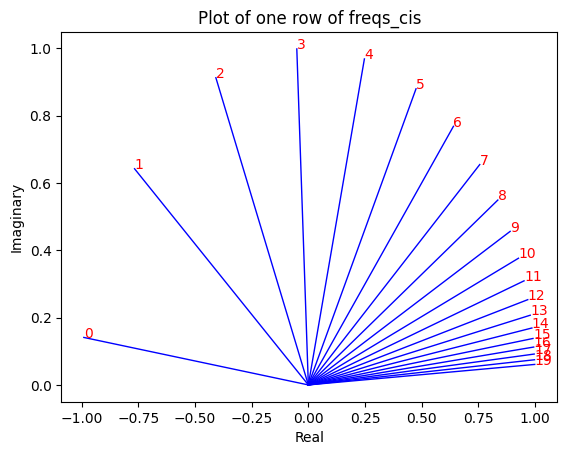

In [23]:
value = freqs_cis[3]
value.shape
plt.figure()
for i, element in enumerate(value[:20]):
    plt.plot([0, element.real], [0, element.imag], color='blue', linewidth=1, label=f"Index: {i}")
    plt.annotate(f"{i}", xy=(element.real, element.imag), color='red')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Plot of one row of freqs_cis')
plt.show()

### Create RoPE embedding vector using complex numbers

In [24]:
q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
q_per_token_as_complex_numbers.shape

torch.Size([17, 64])

In [25]:
## scratchpad
j = torch.ones([3,2])
j[1,1] = 2
j[2,0]=3
k = torch.view_as_complex(j)
print(k)
l = torch.view_as_real(k)
print(l)

tensor([1.+1.j, 1.+2.j, 3.+1.j])
tensor([[1., 1.],
        [1., 2.],
        [3., 1.]])


In [26]:
# rotate the query vector as complex numbers
q_per_token_as_complex_numbers_rotated = q_per_token_as_complex_numbers * freqs_cis
q_per_token_as_complex_numbers_rotated.shape

torch.Size([17, 64])

In [27]:
q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers_rotated)
q_per_token_split_into_pairs_rotated.shape

torch.Size([17, 64, 2])

In [28]:
q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
q_per_token_rotated.shape

torch.Size([17, 128])

### Key vector embedding

- keys have only 1/4th the number of the weights as queries, this is because the weights for keys are shared across 4 heads at a time, to reduce the number of computations need
- keys are also rotated to add positional info, just like queries because of the same reasons

In [29]:
k_layer0 = model["layers.0.attention.wk.weight"]
k_layer0 = k_layer0.view(n_kv_heads, k_layer0.shape[0] // n_kv_heads, dim)
k_layer0.shape

torch.Size([8, 128, 4096])

In [30]:
k_layer0_head0 = k_layer0[0]
k_layer0_head0.shape

torch.Size([128, 4096])

In [31]:
k_per_token = torch.matmul(token_embeddings, k_layer0_head0.T)
k_per_token.shape

torch.Size([17, 128])

##### Apply the rotational positional embedding to the key vectors

In [32]:
k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
k_per_token_split_into_pairs.shape

torch.Size([17, 64, 2])

In [33]:
k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
k_per_token_as_complex_numbers.shape

torch.Size([17, 64])

In [34]:
k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)
k_per_token_split_into_pairs_rotated.shape

torch.Size([17, 64, 2])

In [35]:
k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
k_per_token_rotated.shape

torch.Size([17, 128])

### Self Attention
Multiply Query & Key matrices

In [36]:
qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(head_dim)**0.5
qk_per_token.shape

torch.Size([17, 17])

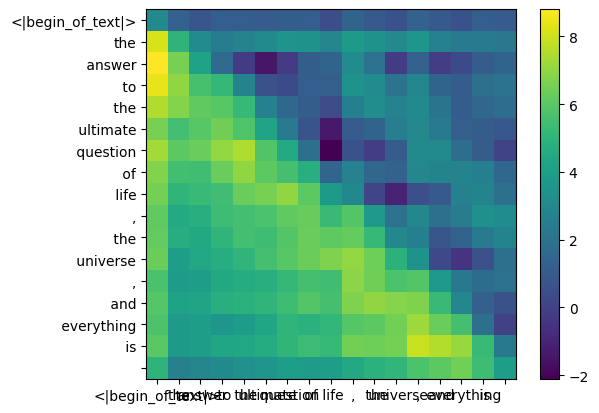

In [37]:
def display_qk_heatmap(qk_per_token):
    _, ax = plt.subplots()
    im = ax.imshow(qk_per_token.to(float).detach(), cmap='viridis')
    ax.set_xticks(range(len(prompt_split_as_tokens)))
    ax.set_yticks(range(len(prompt_split_as_tokens)))
    ax.set_xticklabels(prompt_split_as_tokens)
    ax.set_yticklabels(prompt_split_as_tokens)
    ax.figure.colorbar(im, ax=ax)
    
display_qk_heatmap(qk_per_token)

In [38]:
# Mask out the future tokens
mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
mask = torch.triu(mask, diagonal=1)
mask

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -in

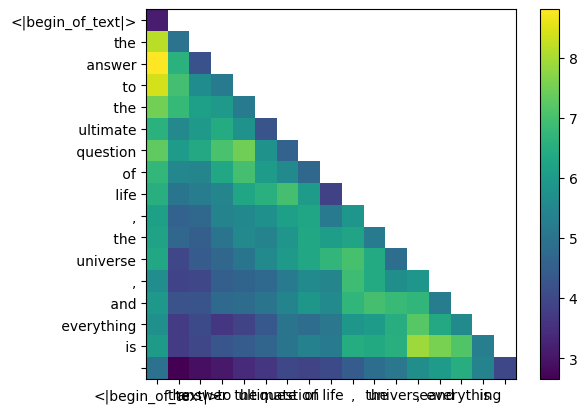

In [39]:
qk_per_token_after_masking = qk_per_token + mask
display_qk_heatmap(qk_per_token_after_masking)

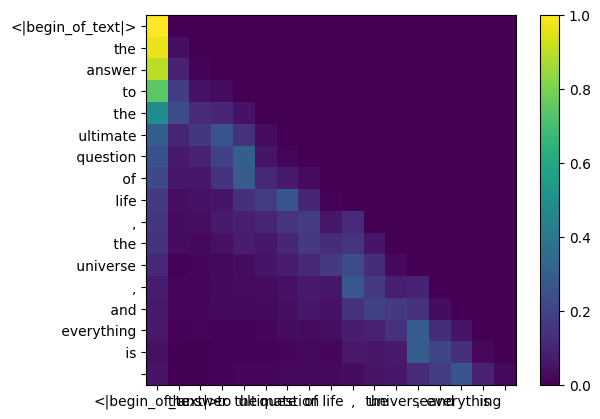

In [40]:
# Apply softmax after masking attention weights
qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
display_qk_heatmap(qk_per_token_after_masking_after_softmax)

### Apply Value vectors for Attention
We need to softmax the QK matrix to do a weighted average of the value vectors. 

In [41]:
v_layer0 = model["layers.0.attention.wv.weight"]
print(v_layer0.shape)
v_layer0 = v_layer0.view(n_kv_heads, v_layer0.shape[0] // n_kv_heads, dim)
v_layer0.shape

torch.Size([1024, 4096])


torch.Size([8, 128, 4096])

In [42]:
v_layer0_head0 = v_layer0[0]
v_layer0_head0.shape

torch.Size([128, 4096])

In [43]:
v_per_token = torch.matmul(token_embeddings, v_layer0_head0.T)
v_per_token.shape

torch.Size([17, 128])

In [44]:
qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
qkv_attention.shape

torch.Size([17, 128])

## Full Attention Loop
Up above was the attention value for the first layer and the first head
now we will run a loop and perform the exact same math but for every cell in the first layer

**Good overview for the full attention mechanism altogether**

In [45]:
qkv_attention_store = []

for head in range(n_heads):
    q_layer0_head = q_layer0[head] # 128,4096 (where 4096 is the dim of the word embedding)
    k_layer0_head = k_layer0[head//4] # key weights are shared across 4 heads (module operator which just results in 0,1,2,3 ie 4 values of when 32 is divided by 4)
    v_layer0_head = v_layer0[head//4] # value weights are shared across 4 heads
    q_per_token = torch.matmul(token_embeddings, q_layer0_head.T)
    k_per_token = torch.matmul(token_embeddings, k_layer0_head.T)
    v_per_token = torch.matmul(token_embeddings, v_layer0_head.T)

    # positional embedding applied to query vectors
    q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
    q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
    q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
    
    # positional embedding applied to key vectors
    k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
    k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
    k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)

    # create a mask over future tokens for attention
    qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
    mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
    mask = torch.triu(mask, diagonal=1)
    qk_per_token_after_masking = qk_per_token + mask
    qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)

    # multiply by value weights to get the QKV for self attention
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    qkv_attention_store.append(qkv_attention)

print(f"len(qkv_attention_store) -> {len(qkv_attention_store)}")
print(f"qkv_attention_store[0].shape -> {qkv_attention_store[0].shape}")

len(qkv_attention_store) -> 32
qkv_attention_store[0].shape -> torch.Size([17, 128])


#### Merge all the attention heads back together
We now have a the qkv_attention matrix for all 32 heads on the first layer, next im going to merge all attention scores into one large matrix of size [17x4096]
The last thing to do for a layer 0 attention is to multiply the QKV of attention tokens with the attention weight matrix for the layer


In [46]:
stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
stacked_qkv_attention.shape

torch.Size([17, 4096])

In [47]:
w_layer0 = model["layers.0.attention.wo.weight"]
w_layer0.shape

torch.Size([4096, 4096])

This is a simple linear layer so we will just matmul the vectors with the weight matrix

In [48]:
embedding_delta = torch.matmul(stacked_qkv_attention, w_layer0.T)
embedding_delta.shape

torch.Size([17, 4096])

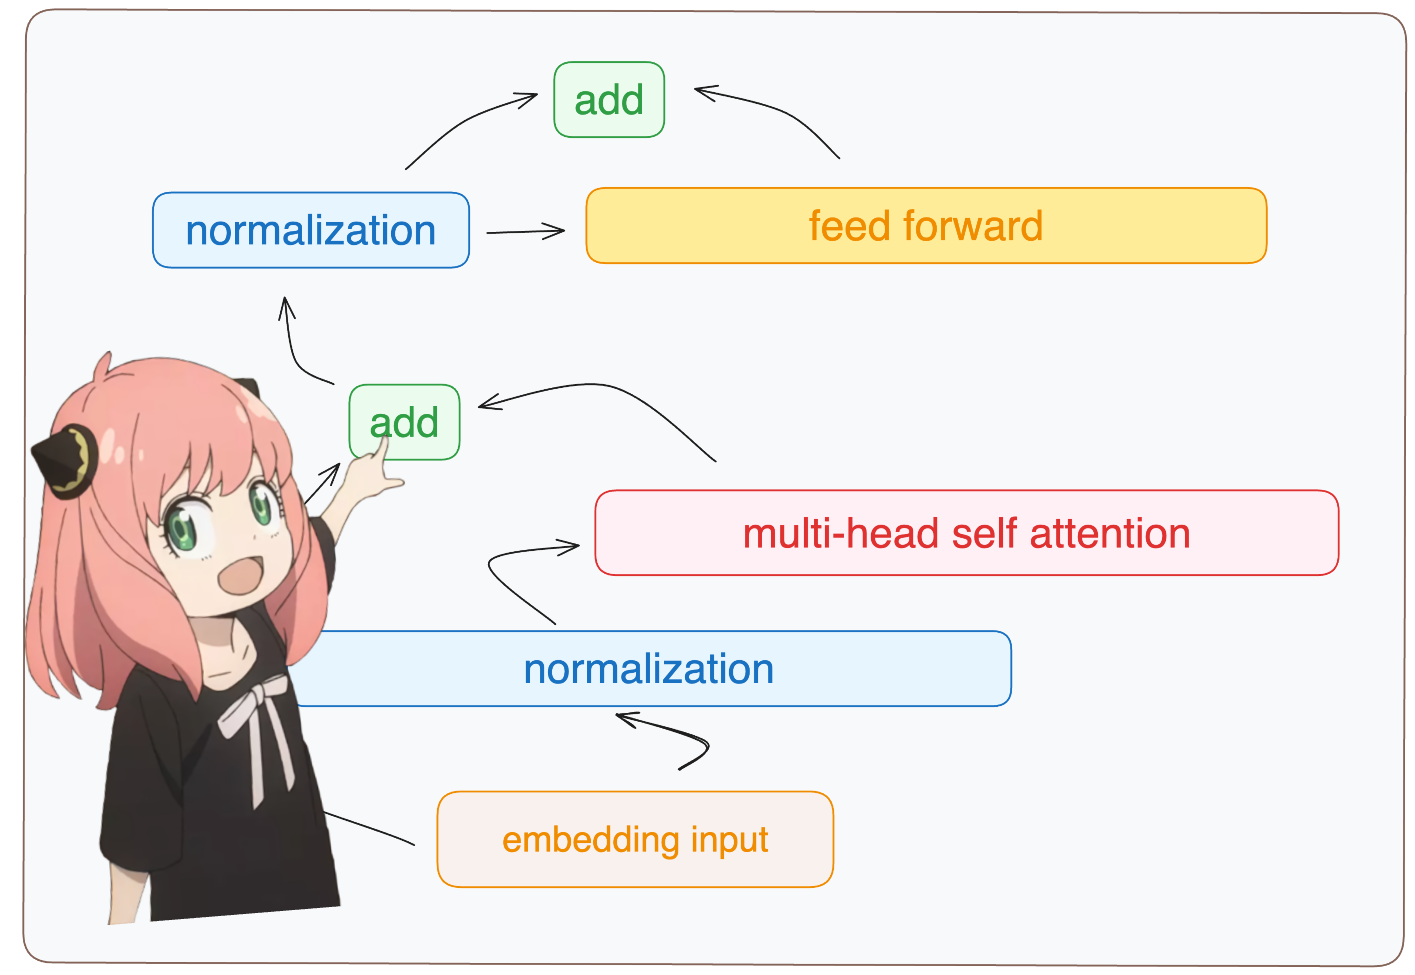

In [49]:
embedding_after_edit = token_embeddings_unnormalized + embedding_delta
embedding_after_edit.shape

torch.Size([17, 4096])

### Normalize and then run a feedforward neural network through the embedding delta

In [50]:
embedding_after_edit_normalized = rms_norm(embedding_after_edit, model["layers.0.ffn_norm.weight"])
embedding_after_edit_normalized.shape

torch.Size([17, 4096])

### SwiGLU Feed forward neural network

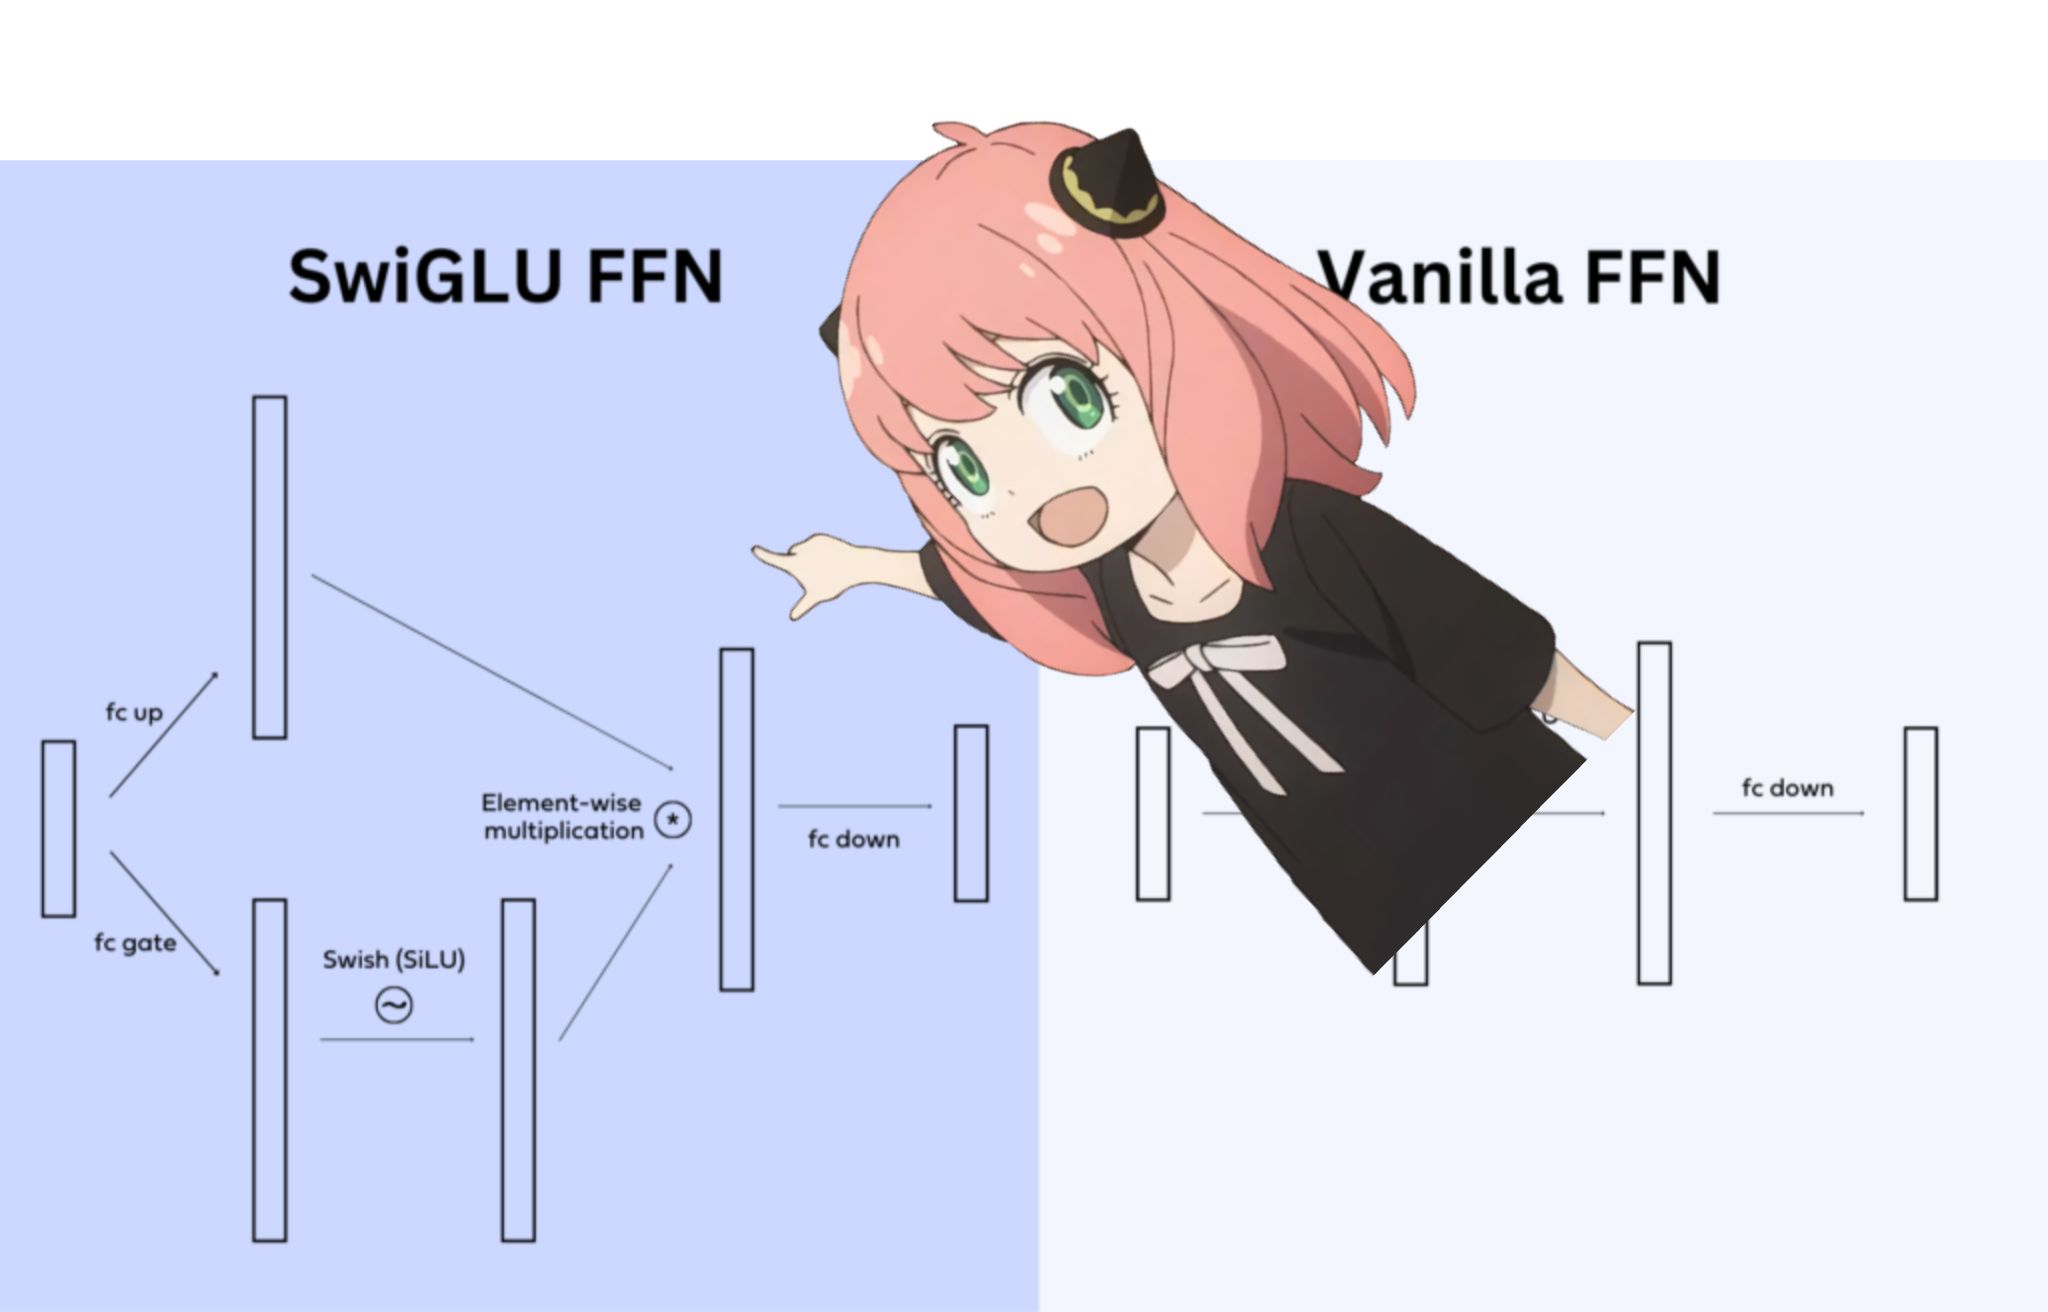
In llama3 they used a SwiGLU feedforward neural network. This network architecture is really good at adding non linearity when needed by the model
It is pretty standard to use this feed forward network architecture in LLMs these days


In [51]:
w1 = model["layers.0.feed_forward.w1.weight"]
w2 = model["layers.0.feed_forward.w2.weight"]
w3 = model["layers.0.feed_forward.w3.weight"]

print(f"w1 -> {w1.shape}")
print(f"w2 -> {w2.shape}")
print(f"w3 -> {w3.shape}")
# output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
# output_after_feedforward.shape
fc_gate  = torch.matmul(embedding_after_edit_normalized, w1.T)
print(f"fc_gate -> {fc_gate.shape}")
siLU_fc_gate = torch.functional.F.silu(fc_gate)
print(f"siLU_fc_gate -> {siLU_fc_gate.shape}")
fc_up = torch.matmul(embedding_after_edit_normalized, w3.T)
print(f"fc_up -> {fc_up.shape}")
elem_wise_mult = siLU_fc_gate * fc_up
print(f"elem_wise_mult -> {elem_wise_mult.shape}")
fc_down = torch.matmul(elem_wise_mult, w2.T)
print(f"output_after_feedforward / fc_down -> {fc_down.shape}")
output_after_feedforward  = fc_down



w1 -> torch.Size([14336, 4096])
w2 -> torch.Size([4096, 14336])
w3 -> torch.Size([14336, 4096])
fc_gate -> torch.Size([17, 14336])
siLU_fc_gate -> torch.Size([17, 14336])
fc_up -> torch.Size([17, 14336])
elem_wise_mult -> torch.Size([17, 14336])
output_after_feedforward / fc_down -> torch.Size([17, 4096])


In [52]:
# Add the feed forward output to that of the normalized attention output
layer_0_embedding = embedding_after_edit+output_after_feedforward
layer_0_embedding.shape

torch.Size([17, 4096])

### Layer 0 done
- We finally have new edited embeddings for each token after the first layer
- Just 31 more layers to go before we are done -> just a for loop
- You can imagine this edited embedding as having information about all queries asked on the first layer
- Now each layer will encode more and more complex queries on the questions asked, until we have an embedding that knows everything about the next token that we need

## Everything all at once

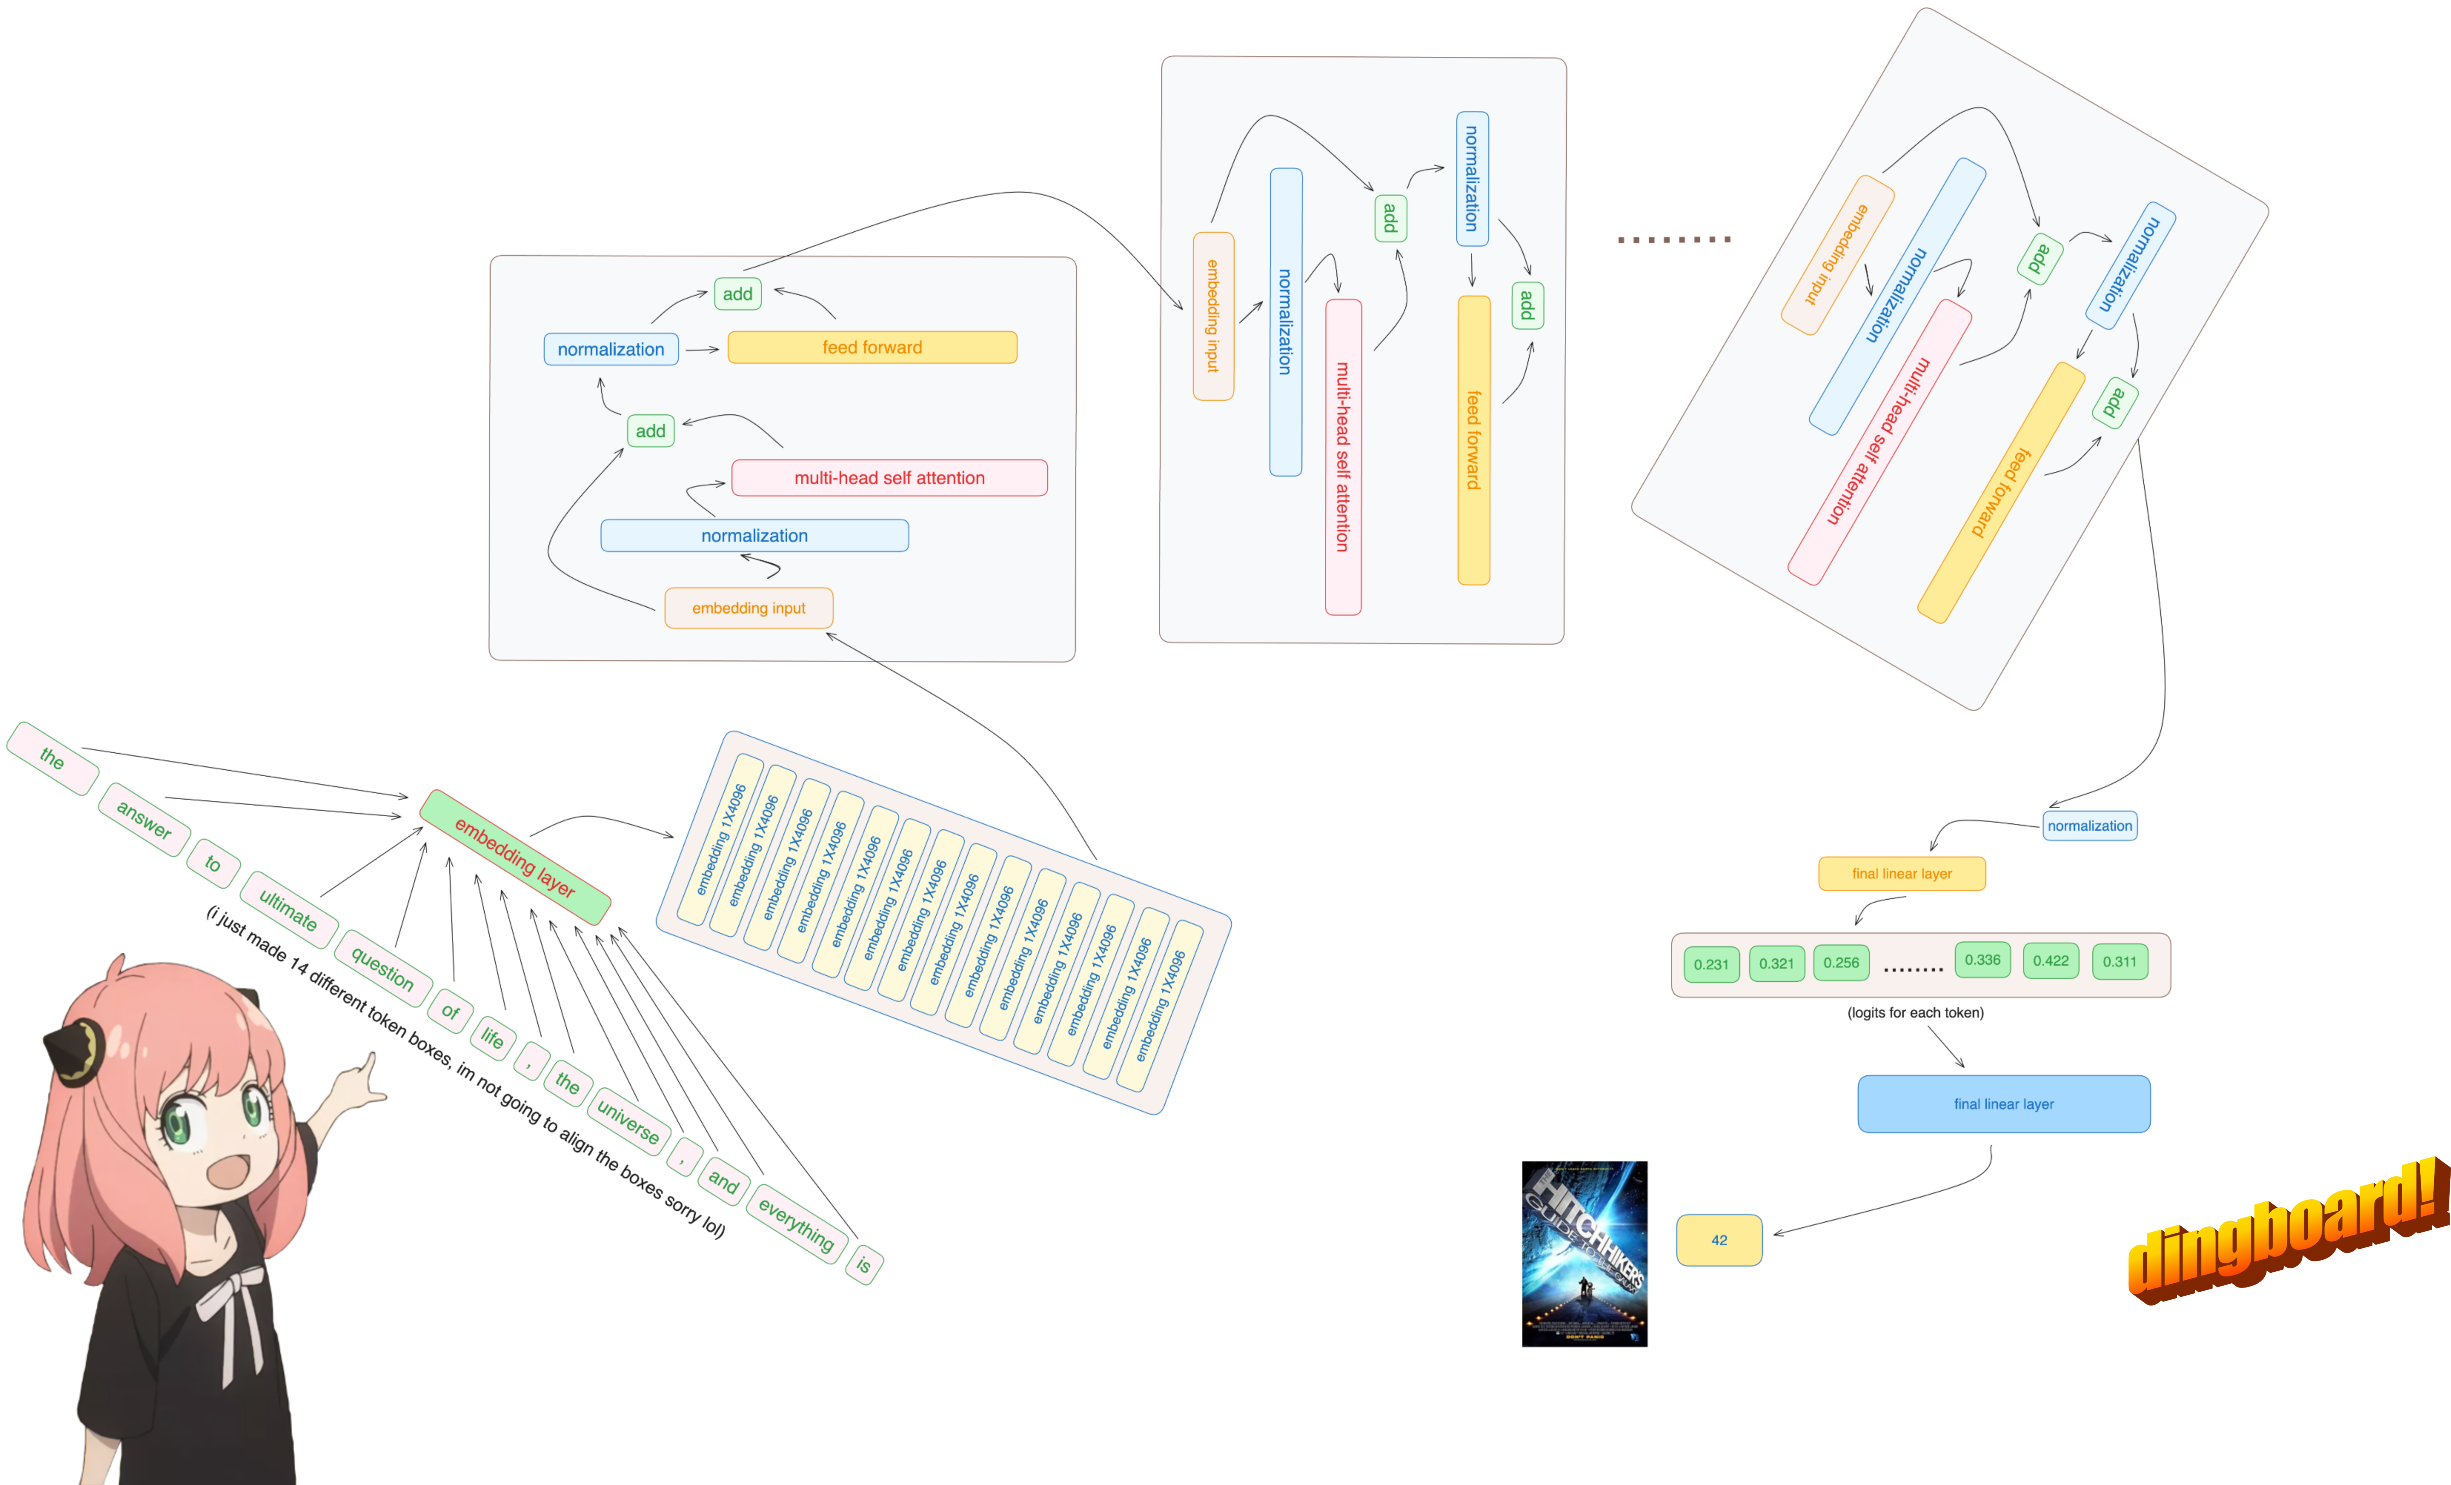

In [53]:

final_embedding = token_embeddings_unnormalized # initialize with the token wise embeddings
for layer in range(n_layers):
    qkv_attention_store = []
    layer_embedding_norm = rms_norm(final_embedding, model[f"layers.{layer}.attention_norm.weight"])
    # Fetch the QKV for this layer
    q_layer = model[f"layers.{layer}.attention.wq.weight"]
    q_layer = q_layer.view(n_heads, q_layer.shape[0] // n_heads, dim)
    k_layer = model[f"layers.{layer}.attention.wk.weight"]
    k_layer = k_layer.view(n_kv_heads, k_layer.shape[0] // n_kv_heads, dim)
    v_layer = model[f"layers.{layer}.attention.wv.weight"]
    v_layer = v_layer.view(n_kv_heads, v_layer.shape[0] // n_kv_heads, dim)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    for head in range(n_heads):
        q_layer_head = q_layer[head] # 128,4096 (where 4096 is the dim of the word embedding)
        k_layer_head = k_layer[head//4] # key weights are shared across 4 heads (module operator which just results in 0,1,2,3 ie 4 values of when 32 is divided by 4)
        v_layer_head = v_layer[head//4] # value weights are shared across 4 heads
        q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T)
        k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T)
        v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T)

        # positional embedding applied to query vectors
        q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
        q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
        q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
        q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
        
        # positional embedding applied to key vectors
        k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
        k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
        k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
        k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)

        # create a mask over future tokens for attention
        qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
        mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
        mask = torch.triu(mask, diagonal=1)
        qk_per_token_after_masking = qk_per_token + mask
        qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)

        # multiply by value weights to get the QKV for self attention
        qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
        qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
        qkv_attention_store.append(qkv_attention)

    # stack all the heads back together and run a linearprojection through the Wo matrix
    stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    embedding_delta = torch.matmul(stacked_qkv_attention, w_layer.T)

    # add to the unnormalized layer wise embeddings input
    embedding_after_edit = final_embedding + embedding_delta

    # normalize the embeddings + attention embeddings
    embedding_after_edit_normalized = rms_norm(embedding_after_edit, model[f"layers.{layer}.ffn_norm.weight"])

    # run the SwiGLU feed forward network
    w1 = model[f"layers.{layer}.feed_forward.w1.weight"]
    w2 = model[f"layers.{layer}.feed_forward.w2.weight"]
    w3 = model[f"layers.{layer}.feed_forward.w3.weight"]
    output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
    # fc_gate  = torch.matmul(embedding_after_edit_normalized, w1.T) # up projection with non-linearity
    # siLU_fc_gate = torch.functional.F.silu(fc_gate)
    # fc_up = torch.matmul(embedding_after_edit_normalized, w3.T) # up projection
    # elem_wise_mult = siLU_fc_gate * fc_up
    # output_after_feedforward = torch.matmul(elem_wise_mult, w2.T) # down projection
    # output embedding for this layer
    final_embedding = embedding_after_edit+output_after_feedforward


## End of transformer blocks

- we now have the final embedding - the best guess the model could make about the next token
- the shape of the embedding is the same as regular token embeddings [17x4096] where 17 is the number of input tokens and 4096 is the embedding dim

In [54]:
# Apply a final normalization to the embeddings here
final_embedding = rms_norm(final_embedding, model["norm.weight"])
final_embedding.shape

torch.Size([17, 4096])

### Decode the embedding into the token value
- We will use the output decoder to convert the final embedding into a token
- we use the embedding of the last token to predict the next value

In [55]:
model["output.weight"].shape

torch.Size([128256, 4096])

In [56]:
logits = torch.matmul(final_embedding[-1], model["output.weight"].T)
logits.shape

torch.Size([128256])

#### Decode the final token from the logits of the last layer (no non linearity needs to be applied)

In [57]:
next_token = torch.argmax(logits, dim=-1)
next_token

tensor(2983)

In [58]:
tokenizer.decode([next_token.item()])

'42'

----
## Scratchpad below


In [59]:
path = "/Users/ammarh/.llama/checkpoints/"

In [60]:
with open(path + "Meta-Llama3.1-8B/params.json", "r") as f:
    config = json.load(f)

tokens = load_tiktoken_bpe(path + "Meta-Llama3.1-8B/tokenizer.model")
print(f"tokenizer# {len(tokens)}")
print(f"vocab_size# {config['vocab_size']}")

tokenizer# 128000
vocab_size# 128256


In [61]:
with open(path + "Meta-Llama3.1-8B-Instruct/params.json", "r") as f:
    config = json.load(f)

tokens = load_tiktoken_bpe(path + "Meta-Llama3.1-8B-Instruct/tokenizer.model")
print(f"tokenizer# {len(tokens)}")
print(f"vocab_size# {config['vocab_size']}")

tokenizer# 128000
vocab_size# 128256


In [62]:
with open(path + "Meta-Llama-3-8B/params.json", "r") as f:
    config = json.load(f)

tokens = load_tiktoken_bpe(path + "Meta-Llama-3-8B/tokenizer.model")
print(f"tokenizer# {len(tokens)}")
print(f"vocab_size# {config['vocab_size']}")

tokenizer# 128000
vocab_size# 128256
